In [2]:
import scipy.io
import numpy as np
import networkx as nx
import os
import pandas as pd
from sklearn.cluster import SpectralClustering
# import community  # Install using: pip install python-louvain
import matplotlib.pyplot as plt
import re

In [5]:
excel_file = 'fungal_networks_data/list_of_fungal_networks.xlsx'
fnd_df = pd.read_excel(excel_file, index_col='code')
print(fnd_df.head())


                     species size resources grazing interaction time point  \
code                                                                         
Pp_M_Tokyo_U_N_26h_1      Pp    M     Tokyo       U           N        26h   
Pp_M_Tokyo_U_N_26h_2      Pp    M     Tokyo       U           N        26h   
Pp_M_Tokyo_U_N_26h_3      Pp    M     Tokyo       U           N        26h   
Pp_M_Tokyo_U_N_26h_4      Pp    M     Tokyo       U           N        26h   
Pp_M_Tokyo_U_N_26h_5      Pp    M     Tokyo       U           N        26h   

                      repeat include substrate   -K2 comments  \
code                                                            
Pp_M_Tokyo_U_N_26h_1       1       Y         A   -k2      NaN   
Pp_M_Tokyo_U_N_26h_2       2       Y         A   -k2      NaN   
Pp_M_Tokyo_U_N_26h_3       3     NaN         A  full      NaN   
Pp_M_Tokyo_U_N_26h_4       4       Y         A   -k2      NaN   
Pp_M_Tokyo_U_N_26h_5       5     NaN         A  full      NaN  

/opt/conda/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [32]:
class TreeNode:
    def __init__(self, value):
        self.value = value
        self.left = None
        self.right = None
        
color_dict = {
    'A': 'blue',
    'B': 'red',
    'S': 'green',
}

node1 = TreeNode('Pp_M_Tokyo_U_N_26h_1.txt')
color_dict[fnd_df.at[node1.value[:-4], 'substrate']]

'blue'

In [8]:
##########################################################################################
#                                    ALL FUNCTIONS
##########################################################################################

def get_graph_from_file(file, flag):
    if flag:
        print(f'Reading the network file: {file}\n')
    
    return nx.read_weighted_edgelist(file, nodetype=str)


def graph_properties(G, flag, file):
    '''
    Parameters:
        G (graph)
        flag (int): flag=1 to print graph stats, 0 else
    '''
    
    n = len(G.nodes())
    m = len(G.edges())
    C = nx.transitivity(G)
    degrees = nx.degree(G)
    kis = [k for _,k in degrees]
    kstd = np.std(kis)
    kmean = np.mean(kis)
    max_edges = n * (n - 1) / 2
    edge_density = m / max_edges
    if nx.is_connected(G):
        average_shortest_path_length = nx.average_shortest_path_length(G, weight='weight')
    else :
        average_shortest_path_length = 0
    
    betweenness = nx.betweenness_centrality(G, weight='weight')
    non_zero_betweenness = [value for value in betweenness.values() if value != 0]
    avg_betweenness_centrality = np.mean(non_zero_betweenness)

    total_weight = sum(data['weight'] for _, _, data in G.edges(data=True))
    average_edge_weight = total_weight / G.number_of_edges()

    if flag:
        print("Number of nodes (n):", n)
        print("Number of edges (m):", m)
        print("Clustering Coefficient (C):", C)
        print("Mean Degree (kmean):", kmean)
        print("Degree STD (kstd):", kstd)
        print("Edge density (D):", edge_density)
        print("Average shortest path length: ", average_shortest_path_length)
        print("Average betweeness centrality: ", avg_betweenness_centrality)
        print("Average edge weight: ", average_edge_weight)
        print("\n")
        
    return [C,kstd,kmean,edge_density,average_shortest_path_length,
            avg_betweenness_centrality,average_edge_weight, file]


def get_all_vectors(directory, flag):
    '''
    Parameters:
        directory path (string)
        flag (int): flag=1 to print graph stats, 0 else
    '''
    files = os.listdir(directory)  # Slicing should be done after calling listdir()
    all_graphs = []
    all_graphs_properties = []
    
    flag_count = 0
    files = list(set(files))
    
    for file in files:
        file_pathway = directory+file
        if flag_count >= 5:
            flag = 0
            # break
        
        if os.path.isfile(file_pathway):
            G = get_graph_from_file(file_pathway, flag) 
            p = graph_properties(G, flag, file)
            all_graphs.append(G)
            all_graphs_properties.append(p)
            flag_count += 1
        
    return all_graphs_properties

def euclidean_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))


def lower_distance_matrix(df):
    """
    Calculate the lower half of the distance matrix for vectors stored in a DataFrame using Euclidean
    
    Args:
        df (pandas.DataFrame): DataFrame containing vectors as rows.
        
    Returns:
        pandas.DataFrame: Lower half of the distance matrix.
    """
    
    num_rows = df.shape[0]
    distance_matrix = np.zeros((num_rows, num_rows))
    
    # Calculate pairwise distances
    for i in range(num_rows):
        for j in range(i):
            distance_matrix[i, j] = euclidean_distance(df.iloc[i], df.iloc[j])
    
    # Convert to DataFrame with filename as index
    distance_df = pd.DataFrame(distance_matrix, index=df.index, columns=df.index)
    
    return distance_df


In [34]:
# A Quick Implementation of UPGMA (Unweighted Pair Group Method with Arithmetic Mean)

# lowest_cell:
#   Locates the smallest cell in the table
def lowest_cell(table):
    # Set default to infinity
    min_cell = float("inf")
    x, y = -1, -1

    # Go through every cell, looking for the lowest
    for i in range(len(table)):
        for j in range(len(table[i])):
            if table[i][j] < min_cell:
                min_cell = table[i][j]
                x, y = i, j

    # Return the x, y co-ordinate of cell
    return x, y


# join_labels:
#   Combines two labels in a list of labels
def join_labels(labels, a, b):
    # Swap if the indices are not ordered
    if b < a:
        a, b = b, a

    # Join the labels in the first index
    labels[a] = [labels[a],labels[b]]

    # Remove the (now redundant) label in the second index
    del labels[b]
    
def join_labels(labels, a, b):
    # Swap if the indices are not ordered
    if b < a:
        a, b = b, a

    # Join the labels in the first index
    labels[a] = [labels[a],labels[b]]

    # Remove the (now redundant) label in the second index
    del labels[b]



# join_table:
#   Joins the entries of a table on the cell (a, b) by averaging their data entries
def join_table(table, a, b):
    # Swap if the indices are not ordered
    if b < a:
        a, b = b, a

    # For the lower index, reconstruct the entire row (A, i), where i < A
    row = []
    for i in range(0, a):
        row.append((table[a][i] + table[b][i])/2)
    table[a] = row
    
    # Then, reconstruct the entire column (i, A), where i > A
    #   Note: Since the matrix is lower triangular, row b only contains values for indices < b
    for i in range(a+1, b):
        table[i][a] = (table[i][a]+table[b][i])/2
        
    #   We get the rest of the values from row i
    for i in range(b+1, len(table)):
        table[i][a] = (table[i][a]+table[i][b])/2
        # Remove the (now redundant) second index column entry
        del table[i][b]

    # Remove the (now redundant) second index row
    del table[b]


# UPGMA:
#   Runs the UPGMA algorithm on a labelled table
def UPGMA(table, labels):
    # Until all labels have been joined...
    while len(labels) > 1:
        # Locate lowest cell in the table
        x, y = lowest_cell(table)

        # Join the table on the cell co-ordinates
        join_table(table, x, y)

        # Update the labels accordingly
        join_labels(labels, x, y)

    # Return the final label
    return labels[0]


## A test using an example calculation from http://www.nmsr.org/upgma.htm

# alpha_labels:
#   Makes labels from a starting letter to an ending letter
def alpha_labels(start, end):
    labels = []
    for i in range(ord(start), ord(end)+1):
        labels.append(i)
    return labels

def lower_distance_to_M_data(lower_distance_df):
    """
    Convert lower distance DataFrame to M_data format for UPGMA.
    
    Args:
        lower_distance_df (pandas.DataFrame): Lower half of the distance matrix.
        
    Returns:
        list: M_data list for UPGMA.
    """
    M_data = []
    num_rows = lower_distance_df.shape[0]
    for i in range(num_rows):
        row_data = []
        for j in range(i):
            row_data.append(lower_distance_df.iloc[i, j])
        M_data.append(row_data)
    return M_data

class TreeNode:
    def __init__(self, value):
        self.value = value
        self.left = None
        self.right = None

def list_to_binary_tree(lst):
    if isinstance(lst, str):
        return TreeNode(lst)
    
    root = TreeNode(None)
    root.left = list_to_binary_tree(lst[0])
    
    if len(lst) == 2:
        root.right = list_to_binary_tree(lst[1])
    
    return root

color_dict = {
    'A': 'blue',
    'B': 'red',
    'S': 'green',
}

def get_node_color(node):
    if node.value is not None:
        print(node.value[:-4])
        return color_dict[fnd_df.at[node.value[:-4], 'substrate']]
    else:
        return 'black'
        
def plot_tree(node, x, y, spacing, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    if node is not None:
        ax.plot(x, y, 'o', markersize=12, color='black')  # Plot node
        ax.text(x, y, str(node.value), verticalalignment='center', horizontalalignment='center')  # Add node value as text
        if node.left is not None:
            ax.plot([x, x - spacing], [y, y - 1], '-k')  # Plot left edge
            plot_tree(node.left, x - spacing, y - 1, spacing / 2, ax)  # Recursively plot left subtree
        if node.right is not None:
            ax.plot([x, x + spacing], [y, y - 1], '-k')  # Plot right edge
            plot_tree(node.right, x + spacing, y - 1, spacing / 2, ax)  # Recursively plot right subtree


In [5]:
####### Helpers for clustering #######

# def louvain_clustering(G, flag):
#     partition = community.best_partition(G)
#     num_clusters = len(set(partition.values())) # Count the number of unique community IDs\

#     if flag:
#         # Draw the graph with nodes colored by community
#         pos = nx.spring_layout(G)  # Positions for all nodes
#         plt.figure(figsize=(8, 6))

#         # Draw nodes, coloring them by community
#         node_colors = [partition[n] for n in G.nodes()]
#         nx.draw(G, pos, node_color=node_colors, cmap=plt.cm.tab10, node_size=20)

#         plt.title("Graph with Nodes Colored by Community (Louvain Method)")
#         plt.show()
        
#     return partition, num_clusters

In [6]:
# G = nx.karate_club_graph

In [7]:
# fname1 = 'fungal_networks_data/Conductance_Text_Files/Sc_M_I_U_N_42d_1.txt'
# G = get_graph_from_file(fname1, fname1)

In [8]:
#########    TEST HELPER FUNCTIONS FOR ONE FILE    #########

# partition, num_clusters = louvain_clustering(G, 1)
# graph_properties(G, 1, fname1)
# print(f'Number of clusters = {num_clusters}')

In [38]:
##################     GET ALL GRAPHS AND PROPERTIES     ##################
flag = 0
directory = 'fungal_networks_data/Conductance_Text_Files/'
# gmatrix = get_all_vectors(directory, flag)
gmatrix = pd.read_csv('vectors.csv')
column_names = ['C', 'kstd', 'kmean', 'edge_density','average_shortest_path_length','avg_betweenness_centrality','average_edge_weight','file']
df = pd.DataFrame(gmatrix, columns=column_names)
df.set_index('file', inplace=True)

df

,C,kstd,kmean,edge_density,average_shortest_path_length,avg_betweenness_centrality,average_edge_weight
file,,,,,,,
Rb_M_I_Fc-H_N_20d_1.txt,0.079430,1.627588,2.256983,0.012680,0.000000,0.072076,4255.600195
Pv_M_I+4R_U_N_39d_3.txt,0.061126,1.249432,2.233796,0.002588,0.007653,0.027278,0.000411
Rb_M_I_U_N_18d_2.txt,0.069333,1.999792,2.423841,0.008053,22159.387399,0.056738,3140.542753
Pv_L_I+4xR_U_N_57d_1.txt,0.074269,0.996752,2.641404,0.001855,0.000000,0.029337,0.006161
Pv_M_I_U_N_31d_1.txt,0.041149,1.175326,2.202294,0.001149,0.016257,0.026421,0.000415
...,...,...,...,...,...,...,...
Pv_M_I_U_Hf_22d_2.txt,0.078322,1.431390,2.581844,0.001847,0.117154,0.027449,0.008630
Pv_M_I+4R_U_N_42d_1.txt,0.052120,1.243313,2.237611,0.001423,0.017854,0.032957,0.000658
Pv_M_I+R_U_N_18d_1.txt,0.115268,1.382307,2.978304,0.005886,0.099048,0.040881,0.017027


In [11]:
df.to_csv('vectors.csv', index=True)

In [75]:
df = pd.read_csv('distances.csv')
def replace_with_ln(x):
    if not isinstance(x, str):
        if x > 10:
            return np.log(x)
        return x
    else:
        return x

# Apply the function to all elements of the DataFrame
df_ln = df.applymap(replace_with_ln)
df_ln.to_csv('distances_ln.csv', index=True)

In [69]:
##################     GET DISTANCE MATRIX     ##################
lower_distance_df = lower_distance_matrix(df)
# print(lower_distance_df.to_string(float_format=lambda x: "%.2f" % x))

##################     FINISHED     ##################


In [44]:
n = lower_distance_df.shape[0]
symmetric_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(i + 1):
        symmetric_matrix[i, j] = lower_distance_df.iloc[i, j]
        symmetric_matrix[j, i] = lower_distance_df.iloc[i, j]

# Convert symmetric matrix to DataFrame
symmetric_distance_df = pd.DataFrame(symmetric_matrix, index=lower_distance_df.index, columns=lower_distance_df.columns)

# Display the symmetric distance DataFrame
symmetric_distance_df

file,Rb_M_I_Fc-H_N_20d_1.txt,Pv_M_I+4R_U_N_39d_3.txt,Rb_M_I_U_N_18d_2.txt,Pv_L_I+4xR_U_N_57d_1.txt,Pv_M_I_U_N_31d_1.txt,Rb_M_I_U_N_26d_3.txt,Pp_M_Tokyo_U_N_26h_1.txt,Pv_M_I+4R_U_N_36d_2.txt,Pv_M_I_U_N_27d_1.txt,Pv_L_I+4xR_U_N_36d_4.txt,...,Pp_M_Tokyo_U_N_26h_11.txt,Pv_M_5xI_U_N_33d_3.txt,Pv_M_I_U_Hf_26d_3.txt,Pv_M_I_Fc_Hf_48d_2.txt,Pv_M_I+4R_U_N_27d_1.txt,Pv_M_I_U_Hf_22d_2.txt,Pv_M_I+4R_U_N_42d_1.txt,Pv_M_I+R_U_N_18d_1.txt,Pv_M_I_U_N_18d_3.txt,Pv_M_5xI_U_N_22d_3.txt
file,,,,,,,,,,,,,,,,,,,,,
Rb_M_I_Fc-H_N_20d_1.txt,0.000000,4255.599801,22187.424438,4255.594098,4255.599805,13109.480470,77439.075233,4255.596544,4255.599854,4255.593781,...,4255.572255,4255.596232,4255.589776,4255.583939,4255.599709,4255.591584,4255.599555,4255.583238,4255.599853,4255.597761
Pv_M_I+4R_U_N_39d_3.txt,4255.599801,0.000000,22380.820306,0.479854,0.083426,13047.500922,77899.735886,0.152118,0.094394,0.283851,...,0.922752,0.456321,0.591240,0.450383,0.043477,0.408167,0.016457,0.764005,0.116198,0.346330
Rb_M_I_U_N_18d_2.txt,22187.424438,22380.820306,0.000000,22380.827086,22380.811789,9334.383427,55519.328401,22380.772713,22380.813432,22380.827038,...,22380.592636,22380.786547,22380.690440,22380.825651,22380.815728,22380.710729,22380.810171,22380.727485,22380.820786,22380.827597
Pv_L_I+4xR_U_N_57d_1.txt,4255.594098,0.479854,22380.827086,0.000000,0.475510,13047.507640,77899.742686,0.344897,0.484274,0.216259,...,0.490105,0.156095,0.542775,0.443469,0.450236,0.454102,0.474019,0.523367,0.526988,0.153059
Pv_M_I_U_N_31d_1.txt,4255.599805,0.083426,22380.811789,0.475510,0.000000,13047.492416,77899.727361,0.175327,0.014589,0.304099,...,0.926128,0.477296,0.653139,0.514954,0.112891,0.470381,0.077687,0.811103,0.060932,0.359771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pv_M_I_U_Hf_22d_2.txt,4255.591584,0.408167,22380.710729,0.454102,0.470381,13047.391406,77899.626277,0.320894,0.483552,0.305944,...,0.724592,0.313506,0.184921,0.132814,0.367124,0.000000,0.405599,0.401932,0.517011,0.331183
Pv_M_I+4R_U_N_42d_1.txt,4255.599555,0.016457,22380.810171,0.474019,0.077687,13047.490797,77899.725745,0.144057,0.089558,0.279597,...,0.915231,0.451338,0.589131,0.450742,0.042652,0.405599,0.000000,0.760839,0.114152,0.341664
Pv_M_I+R_U_N_18d_1.txt,4255.583238,0.764005,22380.727485,0.523367,0.811103,13047.408071,77899.643080,0.639594,0.824218,0.535658,...,0.510405,0.392255,0.269067,0.357774,0.720917,0.401932,0.760839,0.000000,0.863819,0.507343


In [59]:
def func(row):
    index_name = row.name
    return fnd_df.at[index_name[:-4], 'substrate']

# Apply the function to create a new column
symmetric_distance_df['substrate'] = symmetric_distance_df.apply(func, axis=1)
symmetric_distance_df.to_csv('distances_substrate.csv', index_label='index', header=True)

In [50]:
# np.savetxt('distances.csv', symmetric_distance_df, delimiter=',')
# # Assuming df is your DataFrame
symmetric_distance_df.to_csv('distances.csv', index_label='index', header=True)

In [48]:
import scipy.io
import numpy as np

# Save the distance matrix and row/column names to a .mat file
scipy.io.savemat('distance_matrix.mat', {'distances': symmetric_distance_df, 'row_names': symmetric_distance_df.index.tolist(),
                                         'column_names': symmetric_distance_df.columns.tolist()})


In [13]:
##################     SMALL TEST ON THING       ##################

M_labels = lower_distance_df.index.tolist()
M = lower_distance_to_M_data(lower_distance_df)
lst = UPGMA(M, M_labels)


In [65]:
symmetric_distance_df = symmetric_distance_df.drop(columns=['substrate'])


In [78]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform


# Your distance matrix
distances = pd.read_csv('distances_ln.csv')
distances = distances.drop(df.columns[[0, 1]], axis=1)
dist_sub = distances
dist_sub['substrate'] = dist_sub.apply(func, axis=1)

tree = linkage(distances, method='average')  # Use 'average' method for UPGMA

# Plot dendrogram
plt.figure(figsize=(10, 6))
dendrogram(tree, labels=range(1, len(distances) + 1), leaf_rotation=90)
plt.title('UPGMA Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()


TypeError: 'int' object is not subscriptable

<Figure size 2400x600 with 0 Axes>

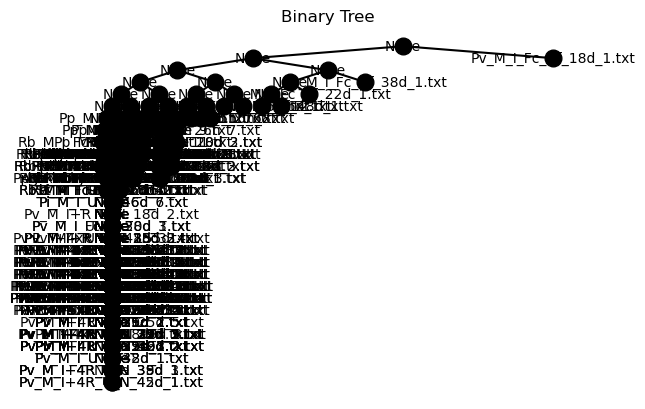

In [35]:
tree = list_to_binary_tree(lst)

# Plot the binary tree
plt.figure(figsize=(24, 6))
plot_tree(tree, 80, 80, 4)
plt.title("Binary Tree")
plt.gca()  # Invert y-axis to have root at the top
plt.axis('off')  # Hide axis
plt.show()

In [75]:
##################     TEST DIST BTWEEN TWO VECS     ##################

# vec1 = df.loc['Pp_M_Tokyo_U_N_26h_7.txt']
# vec2 = df.loc['Pv_L_I+4xR_Fc_N_78d_1.txt']
# dist = np.linalg.norm(vec1 - vec2)
# dist

In [36]:

import sys
sys.path.append('/polo')
from polo import optimal_leaf_ordering
#D = ... your distance matrix
#Z = ... your linkage matrix
optimal_Z = optimal_leaf_ordering(Z, D)



ImportError: cannot import name 'optimal_leaf_ordering' from 'polo' (unknown location)